### Building Chatbot With Multiple Tools Using Langgraph

#### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [7]:
arxiv.invoke("2411.18892")

'Published: 2025-02-01\nTitle: A Comprehensive Survey of Reinforcement Learning: From Algorithms to Practical Challenges\nAuthors: Majid Ghasemi, Amir Hossein Moosavi, Dariush Ebrahimi\nSummary: Reinforcement Learning (RL) has emerged as a powerful paradigm in Artificial Intelligence (AI), enabling agents to learn optimal behaviors through interactions with their environments. Drawing from the foundations of trial and error, RL equips agents to make informed decisions through feedback in the form of'

In [9]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [10]:
wiki.invoke("What did Stephen Hawking found out ?")

'Page: Stephen Hawking\nSummary: Stephen William Hawking (8 January 1942 – 14 March 2018) was an English theoretical astrophysicist, cosmologist, and author who was director of research at the Centre for Theoretical Cosmology at the University of Cambridge. Between 1979 and 2009, he was the Lucasian Professor of Mathematics at Cambridge, widely viewed as one of the most prestigious academic posts in the world.\nHawking was born in Oxford into a family of physicians. In October 1959, at the age of 1'

In [17]:

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [24]:
key = os.getenv("TAVILY_API_KEY")
if key is not None:
    os.environ["TAVILY_API_KEY"] = key
else:
    raise ValueError("TAVILY_API_KEY is not set")


In [26]:
# Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/qt/64kxbqr16ps6hbrf1lzxq5dc0000gn/T/ipykernel_6254/3336424662.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [27]:
tavily.invoke("Provide me the recent AI news for feb 2nd 2026")

[{'title': 'AI News Briefs BULLETIN BOARD for February 2026',
  'url': 'https://radicaldatascience.wordpress.com/2026/02/02/ai-news-briefs-bulletin-board-for-february-2026/',
  'content': 'Key details:\n\n[2/2/2026] Anthropic study shows AI help speeds tasks but significantly harms short-term conceptual understanding – A new randomized controlled trial by Anthropic examines what happens to coding skills when AI writes code during learning. The study focuses on developers learning Trio, a Python library for asynchronous programming, with or without AI assistance.\n\nThe most striking finding shows a large drop in short-term mastery while task speed barely changes. Anthropic designs the study to mirror real workplace learning. Fifty-two software engineers who use Python weekly but have no Trio experience complete guided coding tasks, then take a quiz minutes later. One group uses an AI assistant with full access to their code. The control group codes by hand. [...] [2/2/2026] Ai2 introdu

In [28]:
# Combine all the tools in the list

tools=[arxiv,wiki,tavily]

In [29]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm_with_tools = llm.bind_tools(tools)

In [30]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bnkzj2f29', 'function': {'arguments': '{"query":"Recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 553, 'total_tokens': 573, 'completion_time': 0.053787789, 'completion_tokens_details': None, 'prompt_time': 0.026890814, 'prompt_tokens_details': None, 'queue_time': 0.167552056, 'total_time': 0.080678603}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3272ea2d91', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c22ef-607b-73b1-9282-91522c5363d3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent AI news'}, 'id': 'bnkzj2f29', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 553, 'output_tokens': 20, 'total_tokens': 573})

In [31]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '44t34g8y7',
  'type': 'tool_call'}]

In [32]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

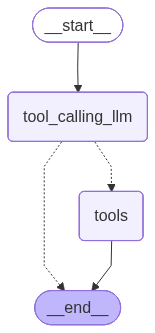

In [33]:
# Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [34]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (qefy3fmej)
 Call ID: qefy3fmej
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [36]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for February 2nd 2026")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for February 2nd 2026
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ss7d13hzs)
 Call ID: ss7d13hzs
  Args:
    query: top 10 recent AI news February 2nd 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Roundup - February 02, 2026 - AI Futures Forum", "url": "https://aiforum.org.uk/ai-news-roundup-february-02-2026/", "content": "AI News Roundup – February 02, 2026 · The AI Hype Index: Grok makes porn, and Claude Code nails your job · Anthropic Moves Into Legal Tech.", "score": 0.9997918}, {"title": "Best Artificial Intelligence Stocks To Watch Today - February 2nd", "url": "https://www.marketbeat.com/instant-alerts/best-artificial-intelligence-stocks-to-watch-today-february-2nd-2026-02-02/", "content": "F